# Mathematical notations



- $t \in {0, 1, ..., T}$
- $x_t$: Noisy image at timestep $t$
- $x_0$: Predicted clean image (from noise prediction)
- $\alpha_t = 1 - \beta_t$: Noise strength
- $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$: Cumulative product of alphas (used for deriving noise level at timestep $t$)
- $\beta_t$: Variance schedule value at time $t$
- $\mu_t$: Mean of the Gaussian for sampling $x_{t-1}$
- $\sigma_t^2$: Variance of the reverse process at time $t$

## Forward diffusion

DDPM forward diffusion process:

$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

This exact formula is implemented exactly in the `forward` function in the DDPM class.

## Reverse diffusion

Equation 11 of the DDPM paper is the sampling / reverse diffusion:

$$
\mu_t(x_t, x_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_0 + \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1 - \bar{\alpha}_t} x_t
$$

And the posterior distribution:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_t(x_t, x_0), \sigma_t^2 \mathbf{I})
$$

## Training & Sampling

![](../notebook_imgs/training.png)
![](../notebook_imgs/sampling.png)

## Linear noise scheduler

$\alpha_t$ controls how much noise we add at timestep $t$.

$\beta_t$ controls the variance of the noise added at timestep $t$.

1) $\alpha_t = 1 - \beta_t$ the noise strength changes at each timestep $t$ (depends on $\beta_t$)
2) $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$

Equations (1) and (2) is from the paper "Denoising Diffusion Probabilistic Models"

3) $x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$ - the forward diffusion process $q(x_t | x_0)$

Equation (3): instead of iteratively adding noise, we do it in one single step (from $x_0$ we get to $x_t$). The $\epsilon$ is random Gaussian noise. I explain this equation in detail in the latex / PDF document (`single_step_forward_process.pdf`).

## Positional embeddings

The formula used is in the "Attention is all you need" paper:

$$
\text{PE}_{(t, 2i)} = \sin\left( \frac{t}{10000^{\frac{2i}{d}}} \right), \quad

\text{PE}_{(t, 2i+1)} = \cos\left( \frac{t}{10000^{\frac{2i}{d}}} \right)
$$

# Imports

In [1]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
import pathlib
from types import FunctionType
from PIL import Image, ImageColor, ImageDraw, ImageFont
import tqdm
# from torchinfo import summary
import abc  # Abstract base class
import numpy as np


# diffusers
from diffusers.models.unets.unet_2d_blocks import (
    AttnDownBlock2D as DiffAttnDownBlock2D,
    DownBlock2D as DiffDownBlock2D,
    CrossAttnDownBlock2D as DiffCrossAttnDownBlock2D,
    CrossAttnUpBlock2D as DiffCrossAttnUpBlock2D,
    AttnUpBlock2D as DiffAttnUpBlock2D,
    UpBlock2D as DiffUpBlock2D,
    ResnetBlock2D as DiffResnetBlock2D,
    UNetMidBlock2DCrossAttn as DiffUNetMidBlock2DCrossAttn,
)
from diffusers.models.embeddings import TimestepEmbedding, Timesteps
from diffusers.models.unets.unet_2d import UNet2DModel

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Hyperparameters

T = 1000 # Timesteps

In [3]:
#@title Device / CUDA

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Using device: {device}')

Using device: cuda


In [4]:
@dataclass
class DataPack:
    train_dataset: Dataset
    train_loader: DataLoader
    val_dataset: Dataset
    val_loader: DataLoader
    transform_to_tensor: Any
    transform_to_pil: Any
    in_channels: int
    out_channels: int
    num_classes: int
    recommended_steps: Tuple[int]
    recommended_attn_step_indexes: List[int]

class MNISTTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * -1 + 1).permute(1,2,0).detach().cpu().numpy()

def get_mnist_loader_and_transform(
    path_to_dataset: str = "./datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform_to_tensor = transforms.ToTensor()
    train_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform_to_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform_to_tensor,
        transform_to_pil=MNISTTransformation(),
        in_channels=1,
        out_channels=1,
        num_classes=10,
        recommended_steps=(1,2,4),
        recommended_attn_step_indexes=[1]
    )

class CifarTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * 127.5 + 127.5).long().clip(0,255).permute(1,2,0).detach().cpu().numpy()

def get_cifar10_loader_and_transform(
    path_to_dataset: str = "./datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5), (.5,.5,.5))
    ])
    transform_to_pil = CifarTransformation()
    train_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform_to_tensor,
        transform_to_pil=transform_to_pil,
        in_channels=3,
        out_channels=3,
        num_classes=10,
        recommended_steps=(1,2,2,2),
        recommended_attn_step_indexes=[1,2]
    )



# Modules

## Sinusodial & Time embeddings modules

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, T: int, output_dim: int) -> None:
        super().__init__()
        self.output_dim = output_dim
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, output_dim, 2) * (-math.log(10000.0) / output_dim))
        pe = torch.zeros(T, output_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x].reshape(x.shape[0], self.output_dim)

class PositionalEmbedding2(nn.Module):
    """
    Sinusoidal positional embedding without explicit slicing.
    """
    def __init__(self, T: int, time_embed_dim: int, device: str) -> None:
        super().__init__()
        self.output_dim = time_embed_dim

        position = torch.arange(T, dtype=torch.float32).unsqueeze(1)  # (T, 1)
        i = torch.arange(time_embed_dim // 2, dtype=torch.float32).unsqueeze(0)  # (1, output_dim//2)

        div_term = torch.exp(-math.log(10000.0) * i / time_embed_dim)  # (1, output_dim//2)
        angles = position * div_term  # (T, output_dim//2)

        pe = torch.stack([torch.sin(angles), torch.cos(angles)], dim=-1)  # (T, output_dim//2, 2)
        pe = pe.view(T, time_embed_dim)  # Interleave sin and cos

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        return self.pe[x]

class PositionalEmbedding3(torch.nn.Module):
    def __init__(self, embedding_dim: int, device: str):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.device = device

        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding

class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            F.silu,
            nn.Linear(4 * n_embd, 4 * n_embd)
        )

    def forward(self, x):
        return self.layers(x)

class TimeEmbeddingProjection(nn.Module):
    """
    Sinusodial positional embeddings, then linearly projected

    pos_emb_output_dim: The sinusodial embeeding dim
    time_emb_dim: The sinusodial embedding projection dim

    Output projection: [time_emb_dim]
    """
    def __init__(self, T: int, time_emb_dim: int = 512, pos_emb_output_dim: int = 128):
        super().__init__()

        self.out = nn.Sequential(
            PositionalEmbedding(T=T, output_dim=pos_emb_output_dim), # Sinusodial embeddings
            nn.Linear(pos_emb_output_dim, time_emb_dim * 4),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        return self.out(t)

## Projection modules

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.ln = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.ln(x)

class SequenceWithTimeEmbedding(nn.Module):
    """
    Container for a sequence of blocks that also takes time embeddings.
    """
    def __init__(self, blocks):
        super().__init__()
        self.models = nn.ModuleList(blocks)

    def forward(self, x, t):
        for model in self.models:
            x = model(x, t)
        return x

## Residual modules and Down, Up modules

In [7]:
class ResBlock(nn.Module):
    """
    Residual block: instead of learning H(x) which is the output of a series of layers that transform an input x into an output H(x), we learn:

    F(x) = H(x) - x

    where F(x) is residual maaping. THe output of the residual block is F(x) + x. The skip connection is what directly adds x to F(X).

    Applies double convolution:

    output = Conv2(Conv1(x) + t_embed)

    We inject the time embeddings in between the convolution blocks because all papers use this technique.
    We can reason that the time embeddings modulate features midway through the residual transformation
    """
    def __init__(self, in_channels: int, out_channels: int,  time_emb_dim: int, num_groups: int = 32):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.SiLU(inplace=True),
        )

        # Here we apply SiLU after we add t_embed and residual connection
        # Here we use in_channels=out_channels because I get errors when I run: "out = self.conv2(out)"
        # After running conv1, the output has 'out_channels' shape, which is the input to the conv2 block
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
        )

        # We use this at the end of the block
        self.activation = nn.SiLU(inplace=True)


        # If in_channels != out_channels, we can't do F(x) + x since they have different shapes.
        # The solution is to use 1x1 convolution to match the shapes
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

        # In forward function we add "out + t_emb". Problem: shape mismatch.
        # Each residual block has different output shape, so we need to match that shape.
        # So we apply linear transformation to match the shape of the output in order to add them together!
        self.time_proj = nn.Linear(time_emb_dim, out_channels)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor, cond_emb: torch.Tensor):
        """
        t_emb: Time embeddings (before projection)
        cond_emb: Conditional information embeddings. This is dropped, we do nothing with it in this block. We only use it in attention related blocks
        """

        # This is identity function if in_channels != out_channels, so its basically 'x'
        residual = self.residual_conv(x)

        out = self.conv1(x)

        # Add the time embeddings projection in between convolutions
        # We might get errors adding "out + t_emb" since t_emb shape is fixed, while the out shape is dynamic
        # So we apply linear projection to match the shape of the output

        # "out" shape: [B, C, H, W]
        t_emb = t_emb.squeeze(1) # [B, 1, time_emb_dim] -> [B, time_emb_dim]
        t = self.time_proj(t_emb) # [B, C]
        t = t.unsqueeze(-1).unsqueeze(-1) # [B, C, 1, 1]
        out = out + t # [B, C, H, W]

        # Apply second convolution: Conv2(Conv1(x) + t)
        out = self.conv2(out)

        # The residual connection F(x) + x
        out = out + residual

        return self.activation(out)

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, is_residual=False, is_debug=False):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        )
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        )
        self.time_emb = MLP(input_dim=time_emb_dim, output_dim=out_channels)
        if in_channels != out_channels:
            self.conv_3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        else:
            self.conv_3 = nn.Identity()
        self.is_debug = is_debug
        self.is_residual = is_residual

    def forward(self, x, t):
        h = self.conv_1(x)
        if t is None:
            return self.conv_3(x) + self.conv_2(h)
        t = self.time_emb(t)
        batch_size, emb_dim = t.shape
        t = t.view(batch_size, emb_dim, 1, 1)
        if self.is_residual:
            return self.conv_3(x) + self.conv_2(h + t)
        else:
            return self.conv_2(h + t)

class DownBlock(nn.Module):
    """
    With skip connection, uses ResBlock
    """
    def __init__(self, in_channels: int, out_channels: int, num_groups: int, time_emb_dim: int):
        super().__init__()
        self.resblock = ResBlock(in_channels, out_channels, num_groups, time_emb_dim)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        t_emb: Time embeddings after projection

        Returns a tuple of:
        - x: The output of the ResBlock
        - pool: The pooled output (for skip connection)
        """
        x = self.resblock(x, t_emb)
        pool = self.pool(x)
        return x, pool

class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, num_groups, time_emb_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # Total input to ResBlock is upsampled + skip: concatenate
        self.resblock = ResBlock(
            in_channels=out_channels + skip_channels,
            out_channels=out_channels,
            num_groups=num_groups,
            time_emb_dim=time_emb_dim
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t_emb: torch.Tensor):
        """
        skip: The skip connection (the 'pool' variable returned from DownBlock)

        t_emb: The time embeddings after projection
        """
        x = self.up(x)

        # If skip and x don't have the same spatial shape due to odd padding, fix here
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)

        x = torch.cat([x, skip], dim=1)
        return self.resblock(x, t_emb)

class MiddleBlock(nn.Module):
    def __init__(self, channels: int, num_groups: int, time_emb_dim: int):
        super().__init__()
        self.resblock1 = ResBlock(channels, channels, num_groups, time_emb_dim)
        self.resblock2 = ResBlock(channels, channels, num_groups, time_emb_dim)

    def forward(self, x, t_emb):
        """
        t_emb: The time embeddings after projection
        """
        x = self.resblock1(x, t_emb)
        x = self.resblock2(x, t_emb)
        return x

class AvgPool2dBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Applies average pooling and then a 1x1 convolution.
        """
        return self.pool(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest') 
        return self.conv(x)

## Attention modules

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

class AttnBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd
        
        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    
    def forward(self, x: torch.Tensor, t_emb: torch.Tensor, cond_emb: torch.Tensor):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)
        
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)
        
        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + Cross-Attention with skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_2(x, cond_emb)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)
        
        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1) 
        
        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)
        
        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)
        
        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short
        
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long


## CLIP modules

In [9]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):
        super().__init__()
        
        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))
    
    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim) 
        x = self.token_embedding(tokens)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding
        
        return x

class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x
        
        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension. 

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)

        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])

        self.layernorm = nn.LayerNorm(768)
    
    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)

        # Apply encoder layers similar to the Transformer's encoder.
        for layer in self.layers: 
            # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
            state = layer(state)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.layernorm(state)
        
        return output

## Color palette modules

In [10]:
def quantize_batch_to_palette_indices(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Quantizes each pixel in the input batch to the nearest palette color index.

    Args:
        images: Tensor of shape [B, 3, H, W], uint8, values in [0, 255]
        palette: Tensor of shape [K, 3], uint8, values in [0, 255]
        k: Number of colors in the palette

    Returns:
        Tensor of shape [B, H, W], with palette indices (0 to K-1) as int64
    """
    assert images.shape[1] == 3, "Images must be RGB"
    B, C, H, W = images.shape

    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()  # [B*H*W, 3]
    palette = palette.float()  # [K, 3]

    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)  # [B*H*W]

    indices = nearest_idx.reshape(B, H, W)  # [B, H, W]

    # TODO: We assume colors = 2**8 so we can convert to uint8
    assert indices.min() >= 0 and indices.max() < 2 ** 8, "Indices must be in range [0, K-1]"
    indices = indices.to(torch.uint8)
    return indices

def reconstruct_from_indices(indices: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Converts quantized palette indices [B, H, W] back to RGB images using the palette [K, 3].

    Args:
        indices: Tensor of shape [B, H, W], dtype uint8 or long
        palette: Tensor of shape [K, 3], dtype uint8

    Returns:
        Tensor of shape [B, 3, H, W], dtype uint8
    """
    assert indices.dim() == 3, "Expected shape [B, H, W]"
    assert palette.dim() == 2 and palette.shape[1] == 3, "Expected palette shape [K, 3]"

    B, H, W = indices.shape
    flat_indices = indices.reshape(-1).long()  # ensure type is long
    palette = palette.to(indices.device)       # move to same device

    # Lookup RGB colors
    rgb = palette[flat_indices]  # [B*H*W, 3]

    # Reshape back to [B, 3, H, W]
    rgb = rgb.reshape(B, H, W, 3).permute(0, 3, 1, 2).contiguous()
    return rgb



class ColorReduction(nn.Module):
    """
    An 8-bit color palette, optioanlly used for RGB images in stable diffusion.
    """
    def __init__(self, palette: torch.Tensor):
        super().__init__()

        self.palette = palette
        self.register_buffer("palette", palette.clone().detach().to(torch.uint8))

    
    def forward(self, imgs: torch.Tensor):
        """
        imgs: Tensor of shape [B, 3, H, W], dtype uint8, values in [0, 255]
        """
        assert imgs.dtype == torch.uint8
        pass

## Modules in progress (combining multiple blocks)

In [11]:
class SpatialSelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        """
        Input: B, C, H, W -> B, H*W, C
        Output: B, C, H, W
        
        embed_dim: Number of channels in the input (C)
        num_heads: Number of attention heads
        """
        super().__init__()
        
        self.n_heads = num_heads
        self.d_embed = embed_dim

        # self.attn = SelfAttention(n_heads, d_embed)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, C, H, W) -> (B, H*W, C)

        # Self attention where Q,K,V = x 
        x_attn, _ = self.attn(x_flat, x_flat, x_flat) # (B, H*W, C) -> (B, H*W, d_embed)
        
        x_attn = x_attn.permute(0, 2, 1).view(B, C, H, W) # (B, H*W, d_embed) -> (B, d_embed, H, W)
        return x_attn

class SpatialCrossAttention(nn.Module):
    def __init__(self, n_heads: int, d_embed: int, d_cross: int):
        """
        Cross-attention between spatial image features and context sequence.
        
        d_embed: # channels of image features (used as query)
        d_cross: # dim of context tokens (used as key/value)
        """
        super().__init__()

        # Save for debugging
        self.n_heads = n_heads
        self.d_embed = d_embed
        self.d_cross = d_cross

        # nn.MultiheadAttention expects all inputs to be same dim so we project context to match d_embed
        self.context_proj = nn.Linear(d_cross, d_embed)
        self.attn = nn.MultiheadAttention(embed_dim=d_embed, num_heads=n_heads, batch_first=True)


    def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        """
        x:       (B, C, H, W)       ← image features
        context: (B, N, d_cross)    ← conditioning sequence
        """
        B, C, H, W = x.shape

        # Reshape x: (B, C, H, W) → (B, H*W, C)
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)  # (B, H*W, C)

        # Project context to d_embed: (B, N, d_cross) → (B, N, d_embed)
        context_proj = self.context_proj(context)     # (B, N, d_embed)

        # Apply cross-attention
        attn_output, _ = self.attn(x_flat, context_proj, context_proj)  # (B, H*W, C)

        # Reshape back to image shape: (B, H*W, C) → (B, C, H, W)
        out = attn_output.permute(0, 2, 1).view(B, C, H, W)

        return out

class ResAttnBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        time_emb_dim: int,
        cond_emb_dim: int,
        num_heads: int = 8,
        dim_head: int = 64,
        num_groups: int = 32,
        use_downsample: bool = False,
        use_upsample: bool = False,
    ):
        """
        This block is used for both downsampling and bottleneck
        For downsampling set use_downsample which will spatially down-size the features
        For bottleneck set use_downsample to false.
        """
        super().__init__()

        # Save for debugging
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.time_emb_dim = time_emb_dim
        self.cond_emb_dim = cond_emb_dim
        self.heads = num_heads
        self.dim_head = dim_head
        self.num_groups = num_groups

        self.use_downsample = use_downsample
        self.use_upsample = use_upsample

        # First ResBlock
        self.res1 = ResBlock(in_channels, out_channels, time_emb_dim, num_groups=num_groups)

        # Self-Attention (acts on channels)
        self.self_attn = SpatialSelfAttention(num_heads=num_heads, embed_dim=out_channels)

        # Cross-Attention (attends to conditional context)
        self.cross_attn = SpatialCrossAttention(n_heads=num_heads, d_embed=out_channels, d_cross=cond_emb_dim)

        # Second ResBlock
        self.res2 = ResBlock(out_channels, out_channels, time_emb_dim, num_groups=num_groups)

        # Optional downsampling
        if use_downsample:
            self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        else:
            self.downsample = nn.Identity()
        
        # Optional upsampling
        if use_upsample:
            # ConvTranspose2d doubles spatial resolution and keep channel count
            self.upsample = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.upsample = nn.Identity()


    def forward(self, x: torch.Tensor, t_emb: torch.Tensor, cond_emb: torch.Tensor):
        """
        x:         (B, C, H, W)
        t_emb:     (B, time_emb_dim)
        cond_emb:  (B, Seq_Len, cond_emb_dim)
        """
        # x: (B, C, H, W)
        x = self.res1(x, t_emb, cond_emb) # out: (B, out_channels, H, W)
        x = self.self_attn(x) # (B, out_channels, H, W) -> (B, out_channels, H, W)
        x = self.cross_attn(x, cond_emb) # (B, out_channels, H, W)
        x = self.res2(x, t_emb, cond_emb) # (B, out_channels, H, W)
        if self.use_downsample:
            x = self.downsample(x) # (B, out_channels, H // 2, W // 2)
        elif self.use_upsample:
            x = self.upsample(x) # (B, out_channels, H * 2, W * 2)
        return x

# Test blocks creation & forward

## ResAttnBlock

In [12]:
b, c, h, w = 32, 1, 32, 32
time_embedding_dim = 128
cond_emb_dim = 768
hidden_dim = 320

x = torch.rand((b, c, h, w))
t_emb = torch.rand((b, time_embedding_dim))
cond_emb = torch.rand((b, 77, cond_emb_dim)) # TODO: We need to store 77 as seq length

# downsampling
res = ResAttnBlock(
    in_channels=c,
    out_channels=hidden_dim,
    time_emb_dim=time_embedding_dim,
    cond_emb_dim=cond_emb_dim,
    use_downsample=True
)
out = res.forward(x, t_emb, cond_emb)
out_b, out_c, out_h, out_w = out.shape
assert out_b == b and out_c == hidden_dim and out_h == h // 2 and out_w == w // 2


# no up/down sampling
res = ResAttnBlock(
    in_channels=c,
    out_channels=hidden_dim,
    time_emb_dim=time_embedding_dim,
    cond_emb_dim=cond_emb_dim
)
out = res.forward(x, t_emb, cond_emb)
out_b, out_c, out_h, out_w = out.shape
assert out_b == b and out_c == hidden_dim and out_h == h and out_w == w


# upsampling
res = ResAttnBlock(
    in_channels=c,
    out_channels=hidden_dim,
    time_emb_dim=time_embedding_dim,
    cond_emb_dim=cond_emb_dim,
    use_upsample=True
)
out = res.forward(x, t_emb, cond_emb)
out_b, out_c, out_h, out_w = out.shape
assert out_b == b and out_c == hidden_dim and out_h == h * 2 and out_w == w * 2

# Compare positional embeddings blocks

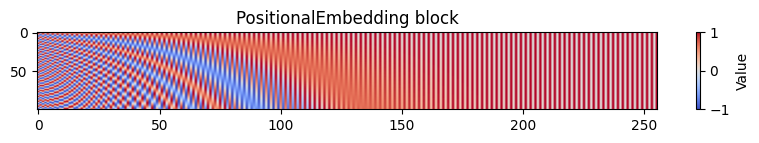

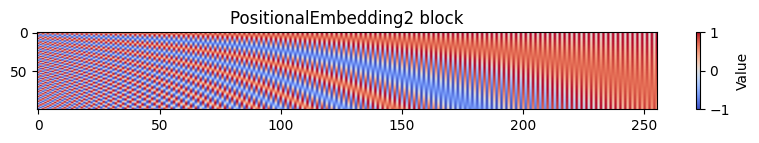

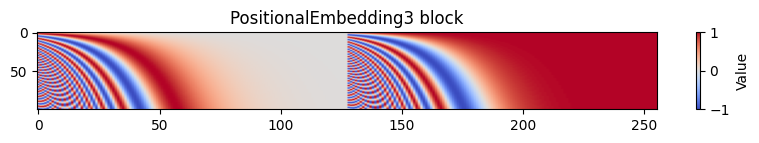

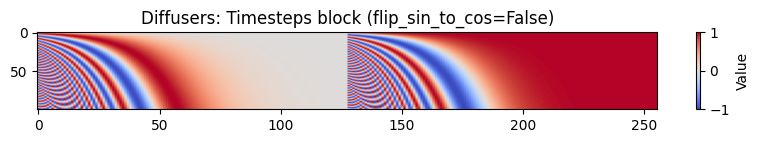

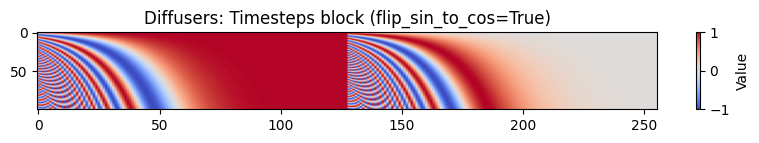

In [13]:
from diffusers.models.embeddings import Timesteps

num_embeds = 100 # Number of vectors
embedding_dim = 256 # Vector size

semb = PositionalEmbedding(T, output_dim=embedding_dim)
semb2 = PositionalEmbedding2(T=T, time_embed_dim=embedding_dim, device=device)
semb3 = PositionalEmbedding3(embedding_dim=embedding_dim, device=device)
semb4 = Timesteps(embedding_dim, False, 0)
semb5 = Timesteps(embedding_dim, True, 0)

time_embeddings = torch.empty(num_embeds, embedding_dim)
time_embeddings2 = torch.empty(num_embeds, embedding_dim)
time_embeddings3 = torch.empty(num_embeds, embedding_dim)
time_embeddings4 = torch.empty(num_embeds, embedding_dim)
time_embeddings5 = torch.empty(num_embeds, embedding_dim)



for i in range(num_embeds):
    embd = semb.forward(torch.Tensor([i]).long())
    time_embeddings[i] = embd

    embd = semb2.forward(torch.Tensor([i]).long())
    time_embeddings2[i] = embd

    embd = semb3.forward(torch.Tensor([i]).long())
    time_embeddings3[i] = embd

    embd = semb4.forward(torch.Tensor([i]).long())
    time_embeddings4[i] = embd
    
    embd = semb5.forward(torch.Tensor([i]).long())
    time_embeddings5[i] = embd

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb.__class__.__name__} block")
# plt.axis('off')  # Optional: hide axes
plt.show()

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings2.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb2.__class__.__name__} block")
# plt.axis('off')  # Optional: hide axes
plt.show()

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings3.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"{semb3.__class__.__name__} block")

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings4.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"Diffusers: {semb4.__class__.__name__} block (flip_sin_to_cos=False)")

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings5.cpu(), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
plt.title(f"Diffusers: {semb5.__class__.__name__} block (flip_sin_to_cos=True)")

# plt.axis('off')  # Optional: hide axes
plt.show()

# Linear, Cosine noise schedulers

In [14]:
class BaseNoiseScheduler(nn.Module, metaclass=abc.ABCMeta):
    def __init__(self, timesteps: int, device: str):
        super().__init__()
        self.timesteps = timesteps
        self.device = device

    @abc.abstractmethod
    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        pass

    @property
    def alpha_t(self):
        return self._alpha_t

    @property
    def beta_t(self):
        return self._beta_t

    @property
    def alpha_cumprod(self):
        return self._alpha_t_cumprod

class LinearNoiseScheduler(BaseNoiseScheduler):
    def __init__(self, device: str, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__(timesteps, device)

        beta_t = torch.linspace(beta_start, beta_end, timesteps)
        alpha_t = 1.0 - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

class CosineNoiseScheduler(BaseNoiseScheduler):
    def __init__(self, device: str, timesteps: int = 1000, s: float = 0.008):
        super().__init__(timesteps, device)

        steps = timesteps + 1
        t = torch.linspace(0, timesteps, steps) / timesteps
        alpha_bar = torch.cos(((t + s) / (1 + s)) * math.pi * 0.5) ** 2
        alpha_bar = alpha_bar / alpha_bar[0]
        beta_t = 1 - (alpha_bar[1:] / alpha_bar[:-1])
        beta_t = torch.clamp(beta_t, max=0.999)

        alpha_t = 1. - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

class ReducedCosineNoiseScheduler(BaseNoiseScheduler):
    """
    A modified version of the CosineNoiseScheduler that allows for a noise strength reduction.
    This scheduler adjusts the alpha_bar to prevent it from going to zero too much
    """
    def __init__(self, device: str, timesteps: int = 1000, s: float = 0.008, noise_strength_reduction: float = 0.0):
        super().__init__(timesteps, device)

        steps = timesteps + 1
        t = torch.linspace(0, timesteps, steps) / timesteps

        # Original alpha_bar calculation
        alpha_bar_original = torch.cos(((t + s) / (1 + s)) * math.pi * 0.5) ** 2
        alpha_bar_original = alpha_bar_original / alpha_bar_original[0]

        # Apply a simple linear adjustment to alpha_bar to prevent it from going to zero too much
        # This will keep alpha_bar_t slightly higher at later timesteps
        # noise_strength_reduction = 0.0 means no change (original behavior)
        # noise_strength_reduction = 1.0 means alpha_bar_t becomes 1 (no noise) for all t
        # A small value like 0.1 or 0.2 might be suitable.
        self.alpha_bar = alpha_bar_original * (1 - noise_strength_reduction) + noise_strength_reduction

        beta_t = 1 - (self.alpha_bar[1:] / self.alpha_bar[:-1])
        beta_t = torch.clamp(beta_t, max=0.999) # Ensure beta_t doesn't exceed 0.999

        alpha_t = 1. - beta_t
        self.alpha_t_cumprod = torch.cumprod(alpha_t, dim=0)

        # Ensure alpha_t_cumprod does not go below a certain threshold
        # This is a more direct way to control the minimum alpha_bar_t
        min_alpha_bar_threshold = 0.01 # Example: prevent alpha_bar from going below 0.01 (1%)
        self.alpha_t_cumprod = torch.clamp(self.alpha_t_cumprod, min=min_alpha_bar_threshold)

        self.register_buffer("_beta_t", beta_t)
        self.register_buffer("_alpha_t", alpha_t)
        self.register_buffer("_alpha_t_cumprod", self.alpha_t_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]
        alpha_bar_t = self.alpha_t_cumprod[t].view(B, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise

# Compare noise schedulers

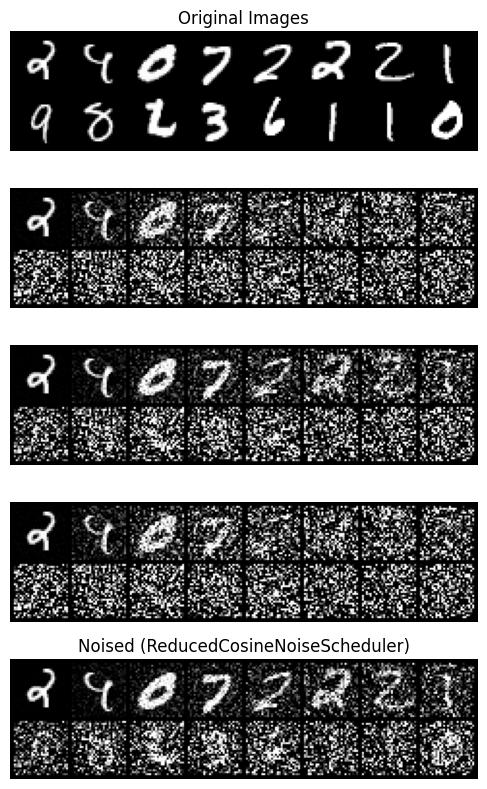

In [15]:
train_dataloader = get_mnist_loader_and_transform().train_loader
# Sample batch
x, y = next(iter(train_dataloader))  # Shape: (B, C, H, W)
x = x[:16]  # Use first 64 images for consistent layout

# Timesteps: left to right → increasing noise
t = torch.linspace(1, T - 1, 16).long()

# Generate one fixed noise tensor for fairness
noise = torch.randn_like(x)

# Linear scheduler
linear_sched = LinearNoiseScheduler(device, timesteps=T)
noised_linear = linear_sched.add_noise(x, noise, t)

# Cosine scheduler
cosine_sched = CosineNoiseScheduler(device, timesteps=T)
noised_cosine = cosine_sched.add_noise(x, noise, t)

# DDPMScheduler from diffusers
ddpm_sched = DDPMScheduler(num_train_timesteps=T, beta_schedule="linear")
alphas_cumprod = ddpm_sched.alphas_cumprod.to(x.device)
sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)
noised_ddpm = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

# Cosine scheduler 2 with noise strength reduction
cosine_sched2 = ReducedCosineNoiseScheduler(device, timesteps=T, noise_strength_reduction=0.4)
noised_cosine2 = cosine_sched2.add_noise(x, noise, t)

# Plot side-by-side
fig, axs = plt.subplots(5, 1, figsize=(30, 8))

axs[0].imshow(torchvision.utils.make_grid(x.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Images")

axs[1].imshow(torchvision.utils.make_grid(noised_linear.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({linear_sched.__class__.__name__})")

axs[2].imshow(torchvision.utils.make_grid(noised_cosine.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({cosine_sched.__class__.__name__})")

axs[3].imshow(torchvision.utils.make_grid(noised_ddpm.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({ddpm_sched.__class__.__name__})")

axs[4].imshow(torchvision.utils.make_grid(noised_cosine2.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[4].set_title(f"Noised ({cosine_sched2.__class__.__name__})")

# Remove axis ticks
for i in range(5):
    axs[i].axis("off")

plt.tight_layout()
plt.show()

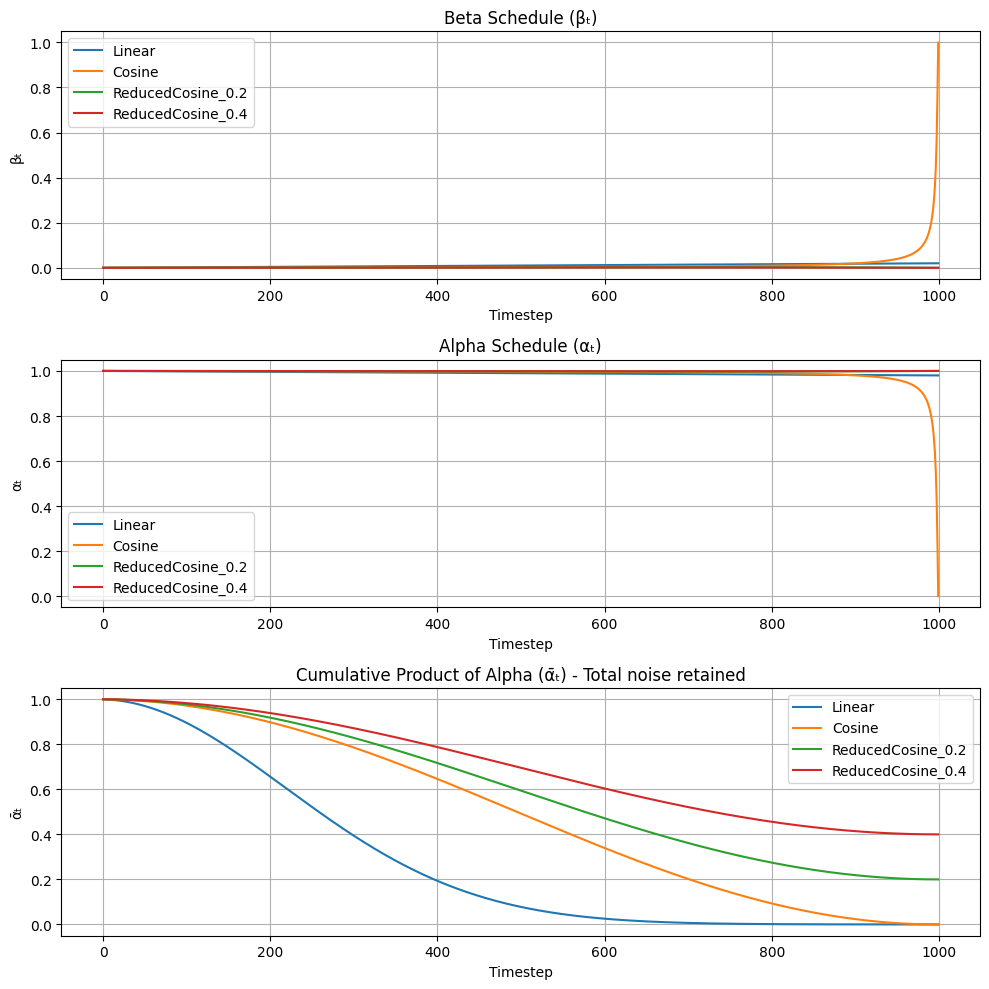

In [16]:
def plot_noise_schedulers(schedulers: dict):
    plt.figure(figsize=(10, 10))

    for i, (name, scheduler) in enumerate(schedulers.items()):
        timesteps = scheduler.timesteps
        x = list(range(timesteps))

        # Plot beta_t
        plt.subplot(3, 1, 1)
        plt.plot(x, scheduler.beta_t.cpu().numpy(), label=name)
        plt.title("Beta Schedule (βₜ)")
        plt.ylabel("βₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

        # Plot alpha_t
        plt.subplot(3, 1, 2)
        plt.plot(x, scheduler.alpha_t.cpu().numpy(), label=name)
        plt.title("Alpha Schedule (αₜ)")
        plt.ylabel("αₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

        # Plot alpha_cumprod (ᾱₜ)
        plt.subplot(3, 1, 3)
        plt.plot(x, scheduler.alpha_cumprod.cpu().numpy(), label=name)
        plt.title("Cumulative Product of Alpha (ᾱₜ) - Total noise retained")
        plt.ylabel("ᾱₜ")
        plt.xlabel("Timestep")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

schedulers = {
    "Linear": LinearNoiseScheduler(device=device),
    "Cosine": CosineNoiseScheduler(device=device),
    "ReducedCosine_0.2": ReducedCosineNoiseScheduler(device=device, noise_strength_reduction=0.2),
    "ReducedCosine_0.4": ReducedCosineNoiseScheduler(device=device, noise_strength_reduction=0.4),
}

plot_noise_schedulers(schedulers)

# UNet

In [17]:
class DropTimeCondParams(nn.Sequential):
    """
    Some layers like Conv2d have no concept of 'time' and 'cond' embeddings.
    So we just pass the correct parameters to the layers that can handle these inputs.
    """
    def forward(self, x: torch.Tensor, time: torch.Tensor, cond: torch.Tensor):
        for layer in self:
            x = layer(x)
        return x

In [18]:
class ConditionalUNet2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        T: int,
        device: str,
        cond_seq_len: int,
        cond_emb_dim: int,
        hidden_dim: int = 320,
        num_attention_heads: int = 8,
        cross_attention_dim: int = 1280,
        encoder_block_types: Tuple[str] = (
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
            "EncoderBlock2D",
        ),
        mid_block_type: str = "MidBlock2DCrossAttn",
        decoder_block_types: Tuple[str] = (
            "DecoderBlock2D", 
            "CrossAttnUpBlock2D", 
            "CrossAttnUpBlock2D", 
            "CrossAttnUpBlock2D"
        ),
        block_out_channels: Tuple[int] = (320, 640, 1280, 1280),
        layers_per_block: Union[int, Tuple[int]] = 2,
        transformer_layers_per_block: int = 1,
        time_cond_proj_dim: int = 256,
        norm_num_groups: int = 32,
        attention_head_dim: int = 8,
    ):
        r"""
        in_channels: Number of input channels (e.g., 1 for grayscale, 3 for RGB).
        out_channels: Number of output channels (e.g., 1 for grayscale, 3 for RGB).
        T: Number of timesteps in the diffusion process.
        num_classes: The number of classes in the dataset. Used to condition the model. TODO: We will use text later, here we only use lables for now.
        hidden_dim: Increase this to increase the number of channels in the UNet (more parameters).
        up_down_blocks: Number of down and up blocks in the UNet. For example, if you want 3 down and 3 up blocks, set this to 3.
        """
        super().__init__()

        # Save for debugging
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.T = T
        self.device = device
        self.cond_seq_len = cond_seq_len
        self.cond_emb_dim = cond_emb_dim
        self.hidden_dim = hidden_dim

        self._check_config(
            encoder_block_types, 
            decoder_block_types, 
            block_out_channels, 
            layers_per_block
        )

        # input
        self.conv_in = nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, padding=1)

        # time
        self.time_proj = Timesteps(
            num_channels=block_out_channels[0], 
            flip_sin_to_cos=True, 
            downscale_freq_shift=0
        )

        time_embed_dim = block_out_channels[0] * 4

        self.time_embedding = TimestepEmbedding(
            in_channels=block_out_channels[0], 
            time_embed_dim=time_embed_dim,
            cond_proj_dim=time_cond_proj_dim
        )

        self.encoders = nn.ModuleList([])
        self.decoders = nn.ModuleList([])

        # params
        only_cross_attention = False

        self.num_upsamplers = 0 # count how many layers upsample the images

        num_attention_heads = (num_attention_heads,) * len(encoder_block_types)
        transformer_layers_per_block = [transformer_layers_per_block] * len(encoder_block_types)
        layers_per_block = [layers_per_block] * len(encoder_block_types)
        cross_attention_dim = (cross_attention_dim,) * len(encoder_block_types)
        attention_head_dim = (attention_head_dim,) * len(encoder_block_types)

        reversed_block_out_channels = list(reversed(block_out_channels))
        reversed_num_attention_heads = list(reversed(num_attention_heads))
        reversed_layers_per_block = list(reversed(layers_per_block))
        reversed_cross_attention_dim = list(reversed(cross_attention_dim))
        reversed_transformer_layers_per_block = (list(reversed(transformer_layers_per_block)))
        only_cross_attention = [only_cross_attention] * len(encoder_block_types)
        only_cross_attention = list(reversed(only_cross_attention))
        output_channel = reversed_block_out_channels[0]

        act_fn = "silu"
        downsample_padding = 1
        dual_cross_attention = False
        blocks_time_embed_dim = time_embedding_dim
        norm_eps = 1e-05
        use_linear_projection = False
        upcast_attention = False
        resnet_time_scale_shift = "default"
        attention_type = "default"
        resnet_skip_time_act = False
        resnet_out_scale_factor = 1.0
        cross_attention_norm = None
        dropout = 0.0

        # encoders
        output_channel = block_out_channels[0]
        for i, encoder_block_type in enumerate(encoder_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1
            encoder_block = self._get_encoder_block(
                encoder_block_type,
                num_layers=layers_per_block[i],
                transformer_layers_per_block=transformer_layers_per_block[i],
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=blocks_time_embed_dim,
                add_downsample=not is_final_block,
                resnet_eps=norm_eps,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
                cross_attention_dim=cross_attention_dim[i],
                num_attention_heads=num_attention_heads[i],
                downsample_padding=downsample_padding,
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention[i],
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
                resnet_skip_time_act=resnet_skip_time_act,
                resnet_out_scale_factor=resnet_out_scale_factor,
                cross_attention_norm=cross_attention_norm,
                attention_head_dim=attention_head_dim[i] if attention_head_dim[i] is not None else output_channel,
                dropout=dropout,
            )
            self.encoders.append(encoder_block)
        
        # middle
        self.mid_block = self._get_mid_block(
            mid_block_type,
            in_channels=input_channel, 
            out_channels=output_channel,
            temb_channels=time_embedding_dim
        )



        # decoders
        for i, decoder_block_type in enumerate(decoder_block_types):
            is_final_block = i == len(block_out_channels) - 1
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]
            input_channel = reversed_block_out_channels[min(i + 1, len(block_out_channels) - 1)]

            # add upsample block for all BUT final layer
            if not is_final_block:
                add_upsample = True
                self.num_upsamplers += 1
            else:
                add_upsample = False

            decoder_block = self._get_decoder_block(
                decoder_block_type, 
                in_channels=input_channel, 
                out_channels=output_channel,
                temb_channels=time_embedding_dim,
                prev_output_channel=prev_output_channel
            )
            self.encoders.append(decoder_block)
            
        
                

    def forward(self, x: torch.Tensor, timesteps: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """
        cond: The conditional information: (Batch_Size, Seq_Len, Dim)
        timesteps: Tensor of b elements where each element is an integer (between 0, T)
        """
        b, c, h, w = x.shape

        # 1. time
        t_emb = self.time_proj(timesteps)
        # t_emb = t_emb.to(torch.float32)

        timestep_cond = None # TODO: For now we don't do conditioning on the time
        t_emb = self.time_embedding(t_emb, timestep_cond)


        # 2. pre-process
        x = self.conv_in(x)

        # skip_connections = []

        # Downsampling / Encoders
        for i, encoder_block in enumerate(self.encoders):
            # skip_connections.append(x)
            if isinstance(encoder_block, DiffDownBlock2D):
                x, res_samples = encoder_block.forward(
                    hidden_states= x, 
                    temb= t_emb
                )
            elif isinstance(encoder_block, DiffCrossAttnDownBlock2D):
                # With cross attention
                x, res_samples = encoder_block.forward(
                    hidden_states= x, 
                    temb= t_emb, 
                    encoder_hidden_states= cond,
                )
            else:
                raise ValueError(f"Unknown encoder block type: {type(encoder_block)}")
            
            down_block_res_samples += res_samples
        
        assert len(down_block_res_samples) == 12

        # Bottleneck / Middle
        if isinstance(self.mid_block, DiffUNetMidBlock2DCrossAttn):
            # With cross-attention
            x = self.mid_block.forward(
                x,
                t_emb,
                encoder_hidden_states= cond
            )
        else:
            raise ValueError(f"Unknown middle block type: {type(self.mid_block)}")
        

        # Upsampling / Decoders
        for i, decoder_block in enumerate(self.decoders):
            # is_final_block = i == len(self.up_blocks) - 1

            res_samples = down_block_res_samples[-len(decoder_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(decoder_block.resnets)]

            if isinstance(decoder_block, DiffUpBlock2D):
                x = decoder_block.forward(
                    hidden_states= x,
                    temb= t_emb,
                    res_hidden_states_tuple= res_samples
                )
            elif isinstance(decoder_block, DiffCrossAttnUpBlock2D):
                # wtih cross attention
                x = decoder_block.forward(
                    hidden_states= x,
                    temb= t_emb,
                    res_hidden_states_tuple= res_samples,
                    encoder_hidden_states= cond
                )
            else:
                raise ValueError(f"Unknown decoder block type: {decoder_block}")

            # x = torch.cat((x, skip_connections.pop()), dim=1) 
            x = decoder_block.forward(x, t_emb, cond)
        
        return x

    def _check_config(
            self, 
            down_block_types: Tuple[str], 
            up_block_types: Tuple[str],
            block_out_channels: Tuple[int],
            layers_per_block: Tuple[int]):
        r"""
        Check config of UNet at initialization
        """
        if len(down_block_types) != len(up_block_types):
            raise ValueError(
                f"Must provide the same number of `down_block_types` as `up_block_types`. `down_block_types`: {down_block_types}. `up_block_types`: {up_block_types}."
            )
        
        if len(block_out_channels) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `block_out_channels` as `down_block_types`. `block_out_channels`: {block_out_channels}. `down_block_types`: {down_block_types}."
            )
        
        if not isinstance(layers_per_block, int) and len(layers_per_block) != len(down_block_types):
            raise ValueError(
                f"Must provide the same number of `layers_per_block` as `down_block_types`. `layers_per_block`: {layers_per_block}. `down_block_types`: {down_block_types}."
            )

    def _get_encoder_block(
            self, 
            encoder_block_type: str, 
            num_layers: int,
            in_channels: int,
            out_channels: int,
            temb_channels: int,
            add_downsample: bool,
            resnet_eps: float,
            resnet_act_fn: str,
            transformer_layers_per_block: int = 1,
            num_attention_heads: Optional[int] = None,
            resnet_groups: Optional[int] = None,
            cross_attention_dim: Optional[int] = None,
            downsample_padding: Optional[int] = None,
            dual_cross_attention: bool = False,
            use_linear_projection: bool = False,
            only_cross_attention: bool = False,
            upcast_attention: bool = False,
            resnet_time_scale_shift: str = "default",
            attention_type: str = "default",
            resnet_skip_time_act: bool = False,
            resnet_out_scale_factor: float = 1.0,
            cross_attention_norm: Optional[str] = None,
            attention_head_dim: Optional[int] = None,
            downsample_type: Optional[str] = None,
            dropout: float = 0.0,
        ):
        if encoder_block_type == "EncoderBlock2D":
            return DiffDownBlock2D(
                num_layers=num_layers,
                in_channels=in_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                dropout=dropout,
                add_downsample=add_downsample,
                resnet_eps=resnet_eps,
                resnet_act_fn=resnet_act_fn,
                resnet_groups=resnet_groups,
                downsample_padding=downsample_padding,
                resnet_time_scale_shift=resnet_time_scale_shift,
            )
        elif encoder_block_type == "CrossAttnDownBlock2D":
            if cross_attention_dim is None:
                raise ValueError("cross_attention_dim must be specified for CrossAttnDownBlock2D")
            return DiffCrossAttnDownBlock2D(
                num_layers=num_layers,
                transformer_layers_per_block=transformer_layers_per_block,
                in_channels=in_channels,
                out_channels=out_channels,
                temb_channels=temb_channels,
                dropout=dropout,
                add_downsample=add_downsample,
                resnet_eps=resnet_eps,
                resnet_act_fn=resnet_act_fn,
                resnet_groups=resnet_groups,
                downsample_padding=downsample_padding,
                cross_attention_dim=cross_attention_dim,
                num_attention_heads=num_attention_heads,
                dual_cross_attention=dual_cross_attention,
                use_linear_projection=use_linear_projection,
                only_cross_attention=only_cross_attention,
                upcast_attention=upcast_attention,
                resnet_time_scale_shift=resnet_time_scale_shift,
                attention_type=attention_type,
            )
        else:
            raise ValueError(f"Unknown encoder type: {encoder_block_type}")

    def _get_mid_block(self, middle_block_type: str, in_channels: int, out_channels: int, temb_channels: int):
        if middle_block_type == "MidBlock2DCrossAttn":
            # out_channels = in_channels
            return DiffUNetMidBlock2DCrossAttn(in_channels=in_channels, temb_channels=temb_channels)
        else:
            raise ValueError(f"Unknown middle block type: {middle_block_type}")

    def _get_decoder_block(self, 
            decoder_block_type: str, 
            in_channels: int, 
            out_channels: int, 
            temb_channels: int,
            prev_output_channel: int
        ):
        if decoder_block_type == "DecoderBlock2D":
            return DiffUpBlock2D(
                in_channels=in_channels, 
                out_channels=out_channels, 
                temb_channels=temb_channels,
                prev_output_channel=prev_output_channel
            )
        elif decoder_block_type == "CrossAttnUpBlock2D":
            return DiffCrossAttnUpBlock2D(
                in_channels=in_channels, 
                out_channels=out_channels, 
                temb_channels=temb_channels,
                prev_output_channel=prev_output_channel
            )
        else:
            raise ValueError(f"Unknown decoder type: {decoder_block_type}")

In [19]:
class DDPM(nn.Module):
    """
    My re-implementation of conditional DDPM that usess a UNet.
    The forward function is the forward diffusion process and returns the loss.
    The sample function returns images sampled from the learned distribution.
    """
    def __init__(
        self,
        T: int,
        unet: ConditionalUNet2D,
        noise_scheduler: BaseNoiseScheduler,
        device: str
    ):
        super().__init__()
        self.T = T
        self.unet = unet.to(device)
        self.noise_sched = noise_scheduler.to(device)
        self.device = device

        # pre-compute sqrt(alpha_t) and sqrt(1 - alpha_t_bar) for all timesteps
        bar_alpha_t = self.noise_sched.alpha_cumprod
        sqrt_bar_alpha_t = torch.sqrt(bar_alpha_t)
        sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t)
        self.register_buffer("sqrt_bar_alpha_t", sqrt_bar_alpha_t)
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", sqrt_minus_bar_alpha_t_schedule)

        # MSE loss is ||noise - predicted_noise||^2
        # This is line 5 in the training algorithm in DDPM paper
        self.criterion = nn.MSELoss()

    def forward(self, imgs: torch.Tensor, t: Union[int, torch.Tensor], cond: torch.Tensor) -> torch.Tensor:
        b, c, h, w = imgs.shape

        # random choose some time steps
        if isinstance(t, int):
            t = torch.tensor([t] * b, device=self.device)
            # t = torch.randint(low=1, high=self.T+1, size=(b,), device=self.device)
        
        assert type(t) == torch.Tensor
        assert t.shape[0] == b

        # get random noise to add it to the images
        noise = torch.randn_like(imgs, device=self.device)

        # get noise image as: sqrt(bar_alpha_t) * x0 + sqrt(1 - bar_alpha_t) * noise
        # where x0 = imgs

        # apply noise via reshaping to 1D tensor (view batch)
        noise_imgs = self.sqrt_bar_alpha_t[t].view((b, 1, 1, 1)) * imgs + \
            self.sqrt_minus_bar_alpha_t_schedule[t].view((b, 1, 1, 1)) * noise

        # get predicted noise from our model
        pred_noise = self.unet.forward(noise_imgs, t, cond)

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        return self.criterion(pred_noise, noise)

    # TODO: We use DDPMSampler, instead of function to control CFG and inference timesteps
    # def sample(self, n_samples, size):
    #     self.eval()
    #     with torch.no_grad():
    #         # get normal noise (Gaussian) as x_T (last image in diffusion process)
    #         x_t = torch.randn(n_samples, *size, device=self.device)

    #         # calculate x_(t-1) on every iteration: [T, T-1, ..., 1, 0]
    #         for t_index in range(self.T, 0, -1):
    #             # The same step is applied to all the batch, thats why we repeat t_index
    #             t_tensor = torch.tensor([t_index], device=self.device).repeat(x_t.shape[0], 1)

    #             # get predicted noise from model
    #             pred_noise = self.unet(x_t, t_tensor)

    #             # get some noise to calculate x_(t-1) as in formula (How to get a Noise)
    #             # for t = 0, noise should be 0
    #             # This is line 3 in the Sampling algorithm in DDPM paper
    #             z = torch.randn_like(x_t, device=self.device) if t_index > 0 else 0

    #             # Line 4 in the Sampling algorithm in DDPM paper
    #             x_t = 1 / torch.sqrt(self.noise_sched.alpha_t[t_index]) * \
    #                 (x_t - pred_noise * (1 - self.noise_sched.alpha_t[t_index]) / self.sqrt_minus_bar_alpha_t_schedule[t_index]) + \
    #                 torch.sqrt(self.noise_sched.beta_t[t_index]) * z

    #         # We reached t = 0, so we return x_0 (the samples)
    #         return x_t

In [20]:
batch_size = 64
data = get_mnist_loader_and_transform(batch_size=batch_size)

model = DDPM(
    T = T,
    unet = ConditionalUNet2D (
        in_channels=data.in_channels,
        out_channels=data.out_channels,
        T=T+1,
        cond_seq_len = 77, # TODO: Get this from CLIPTextModel
        cond_emb_dim = 768, # TODO: Get this from CLIPTextModel
        cross_attention_dim=768,  # <- match CLIP
        device=device,
    ),
    noise_scheduler = CosineNoiseScheduler(device=device, timesteps=T+1),
    device=device
)

data

DataPack(train_dataset=Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: ToTensor(), train_loader=<torch.utils.data.dataloader.DataLoader object at 0x0000016BDE48B8D0>, val_dataset=Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets
    Split: Test
    StandardTransform
Transform: ToTensor(), val_loader=<torch.utils.data.dataloader.DataLoader object at 0x0000016BDE4888D0>, transform_to_tensor=ToTensor(), transform_to_pil=<__main__.MNISTTransformation object at 0x0000016BDE488C90>, in_channels=1, out_channels=1, num_classes=10, recommended_steps=(1, 2, 4), recommended_attn_step_indexes=[1])

In [21]:
num_of_params = sum([p.numel() for p in model.parameters()])

print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# summary(ddpm, input_size=(1, 1, 32, 32))  # adjust input size to your model
def count_params(model):
    lst = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            lst.append((name, param))
            # print(f"{name}: {param.numel()} parameters")
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total}")
    return lst

lst = count_params(model)
lst_sorted = sorted(lst, key=lambda x: x[1].numel(), reverse=True)
for name, param in lst_sorted:
    print(f"{name:<60} {param.numel():,} parameters")

Number of trainable parameters in the model: 527,170,880

Total Trainable Parameters: 527170880
unet.encoders.4.resnets.0.conv1.weight                       29,491,200 parameters
unet.encoders.5.resnets.0.conv1.weight                       22,118,400 parameters
unet.encoders.2.resnets.0.conv2.weight                       14,745,600 parameters
unet.encoders.2.resnets.1.conv1.weight                       14,745,600 parameters
unet.encoders.2.resnets.1.conv2.weight                       14,745,600 parameters
unet.encoders.2.downsamplers.0.conv.weight                   14,745,600 parameters
unet.encoders.3.resnets.0.conv1.weight                       14,745,600 parameters
unet.encoders.3.resnets.0.conv2.weight                       14,745,600 parameters
unet.encoders.3.resnets.1.conv1.weight                       14,745,600 parameters
unet.encoders.3.resnets.1.conv2.weight                       14,745,600 parameters
unet.encoders.4.resnets.0.conv2.weight                       14,745,600 pa

# DDPM Sampler

In [22]:
class DDPMSampler:
    def __init__(self, 
                 model: DDPM, 
                 noise_sched: BaseNoiseScheduler, 
                 device: str, 
                 inference_timesteps: int = 100, 
                 cfg_scale: float = 3.0, 
                 do_cfg: bool = False):
        self.model = model
        self.noise_sched = noise_sched
        self.device = device
        self.cfg_scale = cfg_scale
        self.do_cfg = do_cfg
        self.inference_timesteps = list(range(inference_timesteps, 0, -1)) # 100, 99, ..., 0

    def sample(self, n_samples: int, shape: tuple, context: torch.Tensor):
        x_t = torch.randn(n_samples, *shape, device=self.device)

        for t in tqdm.tqdm(self.inference_timesteps):
            # t_tensor = torch.tensor([t], device=self.device).repeat(n_samples, 1)

            if self.do_cfg:
                # (2B, ...)
                x_input = x_t.repeat(2, 1, 1, 1)
                pred_noise = self.model(x_input, cond=context)

                # Classifier-free guidance
                pred_cond, pred_uncond = pred_noise.chunk(2)
                pred_noise = pred_uncond + self.cfg_scale * (pred_cond - pred_uncond)
            else:
                pred_noise = self.model.forward(x_t, t=t, cond=context)

            z = torch.randn_like(x_t) if t > 1 else 0

            alpha_t = self.noise_sched.alpha_t[t]
            beta_t = self.noise_sched.beta_t[t]
            sqrt_one_minus_bar_alpha = self.noise_sched.sqrt_one_minus_bar_alpha[t]

            x_t = 1 / torch.sqrt(alpha_t) * (
                x_t - pred_noise * (1 - alpha_t) / sqrt_one_minus_bar_alpha
            ) + torch.sqrt(beta_t) * z

        return x_t

def generate(
    model: DDPM,
    device: str,
    samples_shape: tuple[int, int, int],
    n_samples = 16,
    inference_steps = 100,
    do_cfg: bool = False,
    cfg_scale: float = 3.0,
    context = None,
    seed = None,
):
    torch.manual_seed(seed or torch.initial_seed())

    if context is None:
        from transformers import CLIPTextModel, CLIPTokenizer

        b, c, h, w = n_samples, *samples_shape

        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

        prompts = ["a cute cat in space"] * b  # batch of prompts
        text_inputs = tokenizer(prompts, padding="max_length", max_length=77, return_tensors="pt", truncation=True)
        context = text_encoder(**text_inputs).last_hidden_state
        context = context.to(device)

    # Setup sampler
    sampler = DDPMSampler(
        model=model,
        noise_sched=model.noise_sched,
        device=device,
        inference_timesteps=inference_steps,
        cfg_scale=cfg_scale,
        do_cfg=do_cfg
    )

    # Run sampling
    samples = sampler.sample(
        n_samples=n_samples,
        shape=samples_shape,
        context=context
    )
    return samples


In [23]:
def sample_and_plot(model: DDPM, device: str):
    samples = generate(model, device, samples_shape=(1, 32, 32), n_samples=32)
    grid = torchvision.utils.make_grid(samples)
    plt.figure(figsize=(8, 8))
    plt.imshow(data.transform_to_pil(grid).clip(0, 1))
    plt.axis('off')
    plt.title("Generated Samples")
    plt.show()

# Train

In [24]:
def train(
    model: DDPM,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader
):
    training_losses = []
    val_losses = []
    for epoch in range(epochs):
        sample_and_plot(model, device)

        model.train(True)
        training_loss = 0
        val_loss = 0
        pbar = tqdm.tqdm(train_dataloader)
        for index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()

            imgs = imgs.to(device)

            loss = model.forward(imgs, timestep=1000) #TODO: For now its not random

            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            pbar.set_description(f"loss for epoch {epoch}: {training_loss / (index + 1):.4f}")
        model.eval()
        with torch.no_grad():
            for (imgs, labels) in val_dataloader:
                imgs = imgs.to(device)

                loss = model(imgs)

                val_loss += loss.item()
        training_losses.append(training_loss / len(val_dataloader))
        val_losses.append(val_loss / len(val_dataloader))

        sample_and_plot(model, device)
    return training_losses, val_losses

In [26]:
train(
    model=model,
    optimizer=torch.optim.Adam(params=model.parameters(), lr=2e-4),
    epochs=10,
    device=device,
    train_dataloader=data.train_loader,
    val_dataloader=data.val_loader
)

  0%|          | 0/100 [24:16<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1280 and 128x320)

In [ ]:
# _, val_losses = train(
#     model=ddpm,
#     optimizer=torch.optim.Adam(params=ddpm.parameters(), lr=2e-4),
#     epochs=EPOCHS,
#     device=device,
#     train_dataloader=data.train_loader,
#     val_dataloader=data.val_loader
# )

# plt.plot(val_losses, label="Validation Loss")

# plt.legend()

# Save model

In [ ]:
torch.save(model.state_dict(), 'train.pth')

# Create prompt pipeline

In [ ]:
import pipeline
from transformers import CLIPTextModel, CLIPTokenizer

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = text_encoder.eval().to(device)  # disable training

prompt = "A cute cat"
tokens = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
with torch.no_grad():
    text_embeddings = text_encoder(**tokens).last_hidden_state  # shape: (B, 77, 768)

text_embeddings.shape, text_embeddings.min(), text_embeddings.max()

In [ ]:
print(tokens["input_ids"].shape)

In [ ]:
def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

    color_reduction = ColorReduction().to(device)
    color_reduction.load_state_dict(state_dict['unet'], strict=True)

    unet = ConditionalUNet2D().to(device)
    unet.load_state_dict(state_dict['unet'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'unet': unet,
        'clip': clip,
        'color_reduction': color_reduction
    }

In [ ]:
sampler = "ddpm"
num_inference_steps = 50
seed = 42

prompt = "A cat and a dog"
uncond_prompt = "" # Negative prompt

# Higher values means more noise will be added to the input image, so the result will further from the input image. Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

cfg_scale = 8  # min: 1

model_file = ""
models = preload_models_from_standard_weights(model_file, device)


output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=None, # If we give it an image, its Img2Img sample
    strength=strength,
    do_cfg=True,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=device,
    idle_device="cpu",
    tokenizer=tokenizer,
)